In [1]:
#%load_ext autoreload
#%autoreload 2
import scipy.io
import pyopencl as cl
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.artist import Artist
import matplotlib.image as mpimg
import numpy as np
import numpy.matlib
from funciones_shore import *
from os import path
import pandas as pd
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.metrics import mean_squared_error
from skimage.measure import profile_line
from skimage.measure import points_in_poly
from skimage.measure import find_contours
from skimage.filters import threshold_otsu
from scipy import stats
import time
import os, sys
import pickle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import sklearn
if sklearn.__version__[:4] == '0.20':
    from sklearn.externals import joblib
else:
    import joblib
from py import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_classify, utils


# Registrar líneas de costa con fotos nuevas usando CoastSnap
### 1. Recuperar las coordenadas de los puntos de la línea de costa.
Estos se han determinado en una ubicación a lo largo de cada corte transversal.

In [2]:
#load the variables to be used from MATLAB
mat1 = scipy.io.loadmat('data/Edit_Shoreline_Python.mat')
mat2 = scipy.io.loadmat('data/AxesImage4Handles.mat')
#define the variables loaded from MATLAB
RectImage = mat2['RectImage']
sl_xyz = mat1['sl_xyz']
#only the x and y coordinates of the shoreline points are required:
sl_xy = sl_xyz[:,0:2]
#during this initial test, the image data is not in real world coordinates, so the shoreline coordinates also
#need to be calibrated using the calculations below ****(this should be fixed asap, once the code is works)****
sl_xy[:,0] = (sl_xy[:,0]+400)*2
sl_xy[:,1] = (sl_xy[:,1])*2

### 2. Recupere la imagen del plano y trace en ella estos puntos individuales de la línea de costa.
Trace la imagen del plano:

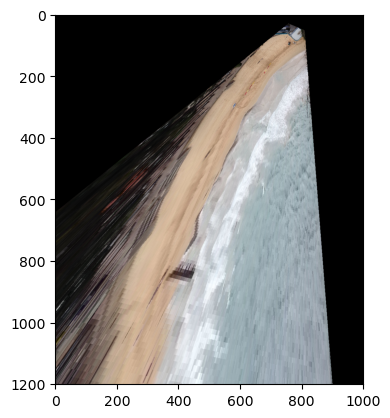

In [3]:
# create figure and axes
fig, ax = plt.subplots()
# plot the image onto these axes
ax.imshow(RectImage)

In [4]:
#define the shorline using the shoreline points' x and y coordinates
sl_poly = Polygon(sl_xy, closed=False, fill=False)

# plot shoreline (contained in sl_poly) over the plan
ax.add_patch(sl_poly)

### 3. Ajuste los puntos de la línea de costa utilizando una interfaz.
La documentación de Matplotlib proporciona el siguiente código para definir la función PolygonInteractor. Esto permite que los puntos de la línea de costa sean refinados interactivamente de la misma manera que el código MATLAB original de CoastSnap.

In [5]:
p = PolygonInteractor(ax, sl_poly)

**Nota:** Hay un problema (sólo estético) cuando se modifica el primer o el último punto: aparece una línea que conecta el primer y el último punto.Esto es probablemente debido a la utilización de la función **Polígono** que previamente tiene la opción cerrada como falsa.
### 4.Obtenga la nueva posición de los puntos de la línea de costa tras el ajuste.
Una vez finalizado el posicionamiento de los puntos de la línea de costa, extraiga las nuevas coordenadas de la línea de costa:


In [6]:
shoreline = ax.lines[0]
newpos = shoreline.get_xydata()

## Cargar Imagen
Este cuaderno presenta alternativas en Python a las funciones críticas usadas en CoastSnap para cargar una imagen a analizar. Ver el cuaderno Load_Image_MATLAB para más detalles de las funciones MATLAB originales.

In [7]:
#load the variables to be used from MATLAB
mat = scipy.io.loadmat('data/load_Image_Python.mat')

### 1. Borrar cifras y datos actuales.
### 2. Obtener la información de "navegación" de la imagen si la imagen ya ha sido cargada previamente.
### 3. Pedir al usuario que seleccione la imagen procesada.

In [8]:
#define the path variable loaded from MATLAB
path = mat['path'][0]

**Nota:** aquí los separadores de ruta son / ya que estoy usando una máquina apple. Dado que la ruta se define manualmente por cada usuario, el separador de ruta siempre debe coincidir con su máquina. En la versión MATLAB, un separador universal podría ser utilizado para asegurarse. No he encontrado la forma de hacerlo aquí.
Generar un cuadro de diálogo para seleccionar la imagen de interés.

En este caso, la ruta del archivo incluye también el nombre del archivo (a diferencia de MATLAB, donde ambos se indican de forma independiente).

In [9]:
file_path= 'data/egmond/Raw/2022/test10.jpg'

### 4. Leer y mostrar el archivo de imagen.
La ruta completa (incluido el nombre del archivo) ya se ha generado en el paso anterior, por lo que puede pasarse directamente a ***mpimg.imread*** para leer la imagen:

In [10]:
#note: file_path has been defined in the code cell above
I = mpimg.imread(file_path)

Mostrar la imagen utilizando ***plt.imshow***

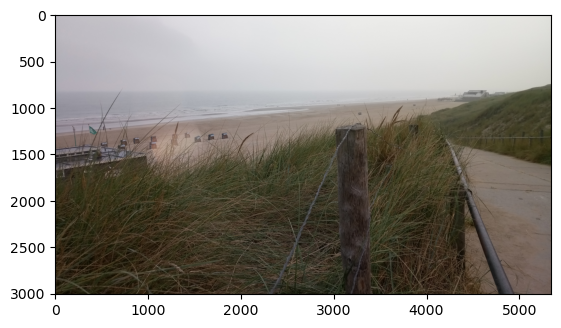

In [11]:
plt.imshow(I)

### 5. Comprobar si la imagen ya ha sido rectificada.
Para ello, podemos utilizar ***str.replace*** para tomar la ruta del archivo de la imagen "Procesada" que se muestra en ese momento y alterarla por la ruta del archivo de lo que sería la imagen "Rectificada" correspondiente si existe (es decir, sustituye la carpeta 'Precesada' por la carpeta 'Rectificada' en la ruta de la imagen:

In [12]:
rect_path = file_path.replace('Processed','Rectified')

Para los otros casos posibles y la modificación de la parte del nombre del archivo a plan:

In [13]:
rect_path = rect_path.replace('Registered','Rectified') #For Registered images
rect_path = rect_path.replace('snap','plan') #Rectified is called plan to keep with Argus conventions
rect_path = rect_path.replace('timex','plan') #For timex images

Ahora se utiliza la función ***path.exists*** de os path para verificar si la ruta de la imagen rectificada existe y, por tanto, si la imagen ha sido rectificada previamente:

In [14]:
os.path.exists(rect_path)

True

### 6. Compruebe si la imagen ya ha sido cartografiada.
Este paso utiliza el mismo proceso que en el paso 5 anterior. Existen funciones adicionales que han sido escritas exclusivamente para CoastSnap, sin embargo, su conversión no presenta ninguna dificultad y se dejará para la tarea final de codificación.
### 7. Extraer los datos de la base de datos del sitio (hoja de cálculo Excel).
Definir las variables que normalmente se definen con CSPparseFilename y CSPloadPaths. (Estas funciones aún no se han convertido pero no requieren funciones especializadas para hacerlo.                                                                                                                                                                                                           

In [15]:
#defining the site name, this would nomally be done through CSPparseFilename
site = 'manly'

#defining the database path, this would normally be generated by CSPloadPaths
DB_path = 'data/'

El nombre del archivo de la base de datos (Excel) se une al final de la ruta de la base de datos:

In [16]:
dbfile = os.path.join(DB_path, 'CoastSnapDB' + '.xlsx')
#read the .xlsx file 
raw = pd.ExcelFile(dbfile)

### 8. Obtener el nivel de marea para la imagen cargada.
Los pasos implicados en esta etapa (ver cuaderno Load_Image_MATLAB para más detalles) requieren funciones escritas exclusivamente para MATLAB. Su conversión a Python no se ha llevado a cabo todavía ya que no se prevé que este paso presente ningún reto de codificación.
## Georrectificar imagen

In [17]:
#Load data from MATLAB
mat = scipy.io.loadmat('data/Georectify_Python.mat')

I = mat['I']
nGcps = mat['nGcps'][0,0]

### 6.Establecer los parámetros desconocidos de la cámara

In [18]:
HFOV_min = mat['HFOV_min']
HFOV_max = mat['HFOV_max']
Nu = mat['Nu']

A = np.arange(5, 500005, 5)
B = np.arange(5, 500005, 5)

fx_max = 0.5*Nu/np.tan(HFOV_min*np.pi/360) #From Eq. 4 in Harley et al. (2019)
fx_min = 0.5*Nu/np.tan(HFOV_max*np.pi/360) #From Eq. 4 in Harley et al. (2019)
fx_min = interpolate.interp1d(A, B, kind='nearest')(fx_min)
fx_max = interpolate.interp1d(A, B, kind='nearest')(fx_max)
print(fx_min)
print(fx_max)

fx = np.arange(fx_min, fx_max+5, 5)


[[1460.]]
[[2815.]]


Cargue los datos generados en MATLAB para utilizarlos en los pasos siguientes:

In [19]:
GlobsOutput = scipy.io.loadmat('data/GlobsOutput.mat')

xyz = GlobsOutput['xyz'].astype(float)
UV = GlobsOutput['UV'].astype(float)
beta0 = GlobsOutput['beta0']

Defina la función que aplica el modelo de cámara estenopeica:

Realiza un ajuste de regresión no lineal de la función ***TESTFITFUNC*** a los datos (U,V) y (x,y,z) proporcionados. para generar las estimaciones de los parámetros desconocidos (en **beta_opt**).

In [20]:
beta_opt, Cov = curve_fit(TESTFITFUNC, xyz, np.concatenate((UV[:,0], UV[:,1])),beta0)
beta_opt
beta = beta_opt

**Pasos requeridos para calcular el error cuadrático medio del ajuste de regresión no lineal en Python**

Aplicar el modelo de cámara estenopeica a la inversa para encontrar las coordenadas (U,V) generadas a partir de las coordenadas mundiales conocidas (x,y,z) utilizando los parámetros ajustados.

In [21]:
UV_pred = TESTFITFUNC(xyz, beta[0], beta[1], beta[2], beta[3], beta[4], beta[5])

Compárelas con las coordenadas UV originales proporcionadas por el usuario:

In [22]:
UV = GlobsOutput['UV'].astype(float)
UV = np.concatenate((UV[:,0], UV[:,1]))
UV_true = UV

Aplicar la función **mean_squared_error**:

In [23]:
mean_squared_error(UV_true, UV_pred)*((2*nGcps)/((2*nGcps)-beta0.shape[1]))

10.010494510486053

### 7. Trace en la imagen las ubicaciones del GCP generadas por los parámetros resueltos de la cámara.

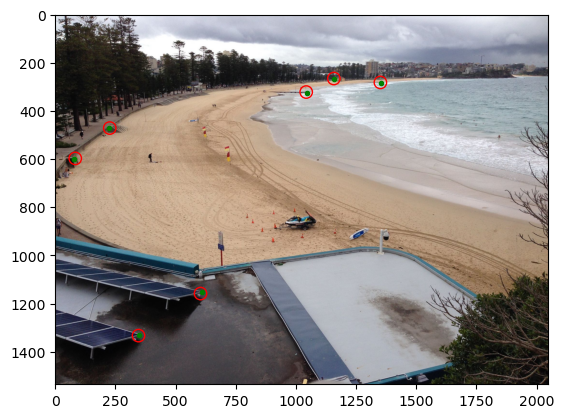

In [24]:
mat = scipy.io.loadmat('data/UV_computed.mat')
UV = mat['UV']
UV_computed = mat['UV_computed'].reshape((-1,2))

fig2, axes = plt.subplots()
axes.imshow(I)
axes.plot(UV[:,0], UV[:,1],'go', markersize = 3)
axes.scatter(UV_computed[:,0], UV_computed[:,1], s=80, facecolors='none', edgecolors='r')

### 8.Crear la imagen del plano
Cargar datos de MATLAB:

In [25]:
mat = scipy.io.loadmat('data/build___rect___products___Python.mat')

images_xy = mat['images_xy']
images_z = mat['images_z']
I = mat['I'].astype(float)
beta = mat['beta']
dn = mat['dn']

Generar una cuadrícula para el espacio mundial que debe cubrirse en la imagen del plano:

In [26]:
[NV, NU, NC] = I.shape
#Detail the minimum and maximum x and y coordinates and the spacing in x and y of the real-world grid
xy = images_xy
z = images_z[0,0]
#Create the x array to be passed to the meshgrid function
x = np.arange(xy[0,0], (xy[0,2] + xy[0,1]), xy[0,1])
#Creates the y array to be passed to the meshgrid function
y = np.arange(xy[0,3], (xy[0,5] + xy[0,4]), xy[0,4])
#Meshgrid generated
X, Y = np.meshgrid(x, y)
images_dn = dn
#Zeros array with same dimensions as the grid and depth of 3 for each of RGB values
images_sumI = np.zeros((len(y),len(x),3))
#Zeros array with 2D grid dimensions
images_N = np.zeros(X.shape)
#Create an array representing the (x,y,z) coordinates of every point in the grid. shape: (nPoints, 3)
xyz = np.column_stack((X.T.flatten(), Y.T.flatten(), np.matlib.repmat(z, len(X.T.flatten()), 1)))


Determinar las coordenadas (U,V) correspondientes a todos los puntos de la cuadrícula: 

In [27]:
#All xyz coordinates in the grid are given their corresponding UV coordinates which are rounded to nearest integer
UV = np.around(TESTFITFUNC(xyz, beta[0,0], beta[0,1], beta[0,2], beta[0,3], beta[0,4], beta[0,5]))
#Order='F' means the reshape is done column by column.
UV = np.reshape(UV, (-1, 2), order='F')

Determinar cuáles de los puntos de la cuadrícula pueden extraer datos de la imagen oblicua:

In [28]:
#Gives the index of all the UV coords which will have pixel data
good = np.where(onScreen(UV[:,0], UV[:,1], NU, NV) == 1)[0]
UV = UV.astype(int)
#arr is an array containing the useful UV coordinates with the V coords on top of the U coords
arr = np.array([UV[good,1], UV[good,0]])
#returns the linear indices of the usful coordinates
ind = np.ravel_multi_index(arr, (NV, NU), mode='clip', order='F')

Transfiera los datos de los píxeles de la imagen oblicua a los puntos correspondientes de la cuadrícula:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Georectified image - Python')

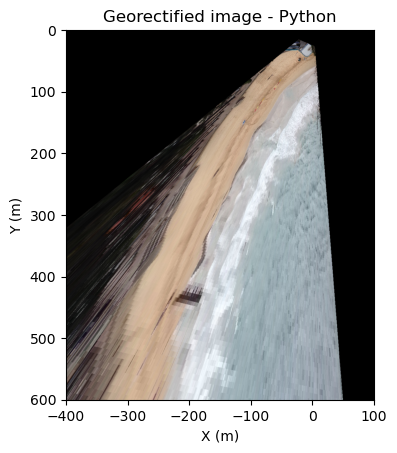

In [29]:
#same as before size of grid with 3 depth for RGB
foo = images_sumI
for i in range(3):
    #Take each of the RGB information arrays
    I3 = I[:,:,i]
    #Reshape it so that it is one column (column by column)
    I3 = np.reshape(I3, (-1, 1), order='F')
    #Extract the data from the image pixels corresponding to xyz grid points
    I2 = I3[ind]
    #Make bar the same shape as the real-world grid
    bar = foo[:,:,i]
    #Straignten it out
    bar = np.reshape(bar, (-1, 1), order='F')
    #The relevant coordinates of bar (real-world grid) will now attain the pixel data
    bar[good] = I2
    #Reshape bar
    bar = np.reshape(bar, (len(images_sumI), -1), order='F')
    #Put the data back into foo to hold it safely
    foo[:,:,i] = bar
images_dn = dn
#x grid axis
images_x = x
#y grid axis
images_y = y
#Pixel info in the grid
images_sumI  = foo
#xyz coords of each grid point
images_xyz = xyz
images_N = np.reshape(images_N, (-1, 1), order='F')
#Puts a 1 in every location where there is pixel data in the grid
images_N[good] = 1
images_N = np.reshape(images_N, (X.shape[0], X.shape[1], 1), order='F')
#Copies N to fit the shape of the RGB grid
N = np.tile(images_N, (1, 1, 3))
#All grid coordinates without pixel data are assigned a NaN value due to the division by 0 from N:
finalImages_timex = (images_sumI/N).astype(int)
plt.imshow(finalImages_timex, extent = (xy[0,0], xy[0,2], xy[0,5], xy[0,3]))
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Georectified image - Python")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Georectified image - Python')

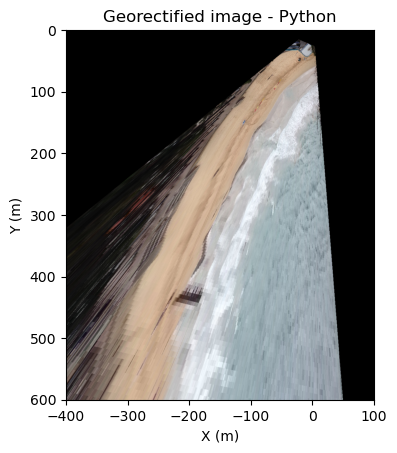

In [30]:
#All grid coordinates without pixel data are assigned a NaN value due to the division by 0 from N:
finalImages_timex = (images_sumI/N).astype(int)
plt.imshow(finalImages_timex, extent = (xy[0,0], xy[0,2], xy[0,5], xy[0,3]))
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Georectified image - Python")

Cargar las variables que se han generado en los pasos anteriores utilizando MATLAB

In [31]:
mat = scipy.io.loadmat('data/MapShorelinePython.mat')
transectsX = mat['transectsX']
transectsY = mat['transectsY']
Iplan = mat['Iplan']

Recoger los valores RGB de los píxeles a lo largo de los transectos.

In [32]:
#P contains all sample data
P = np.empty((0,3))

for i in np.arange(1,transectsX.shape[1]+1,1):
        M1 = transectsY[0,i-1]
        M1 = (M1*2)
        M2 = transectsY[1,i-1]
        M2 = (M2*2)
        N1 = transectsX[0,i-1]
        N1 = ((N1 + 400) * 2)
        N2 = transectsX[1,i-1]
        N2 = ((N2 + 400) * 2)
        prof = profile_line(Iplan, (M1, N1), (M2, N2))
        P = np.append(P, prof, axis = 0)
        if i == transectsX.shape[1]:
            break
        else:
            M1 = transectsY[1,i-1]
            M1 = (M1*2)-1
            M2 = transectsY[0,i]
            M2 = (M2*2)-1
            N1 = transectsX[1,i-1]
            N1 = ((N1 + 400) * 2)
            N2 = transectsX[0,i]
            N2 = ((N2 + 400) * 2)
            prof = profile_line(Iplan, (M1, N1), (M2, N2))
            P = np.append(P, prof, axis = 0)
    

Crear una matriz de valores de rojo menos azul (RmB) para los píxeles muestreados. A partir de estos producir una estimación de la densidad de probabilidad.

In [33]:
RmBsample = P[: , 0] - P[: , 2]
kde = stats.gaussian_kde(RmBsample)
pdf_locs = np.linspace(RmBsample.min(), RmBsample.max(), 400, endpoint=True)

pdf_values = kde(pdf_locs)

El gráfico siguiente sirve simplemente para visualizar la estimación de la densidad

Text(0.5, 1.0, 'Probability distribution (Python)')

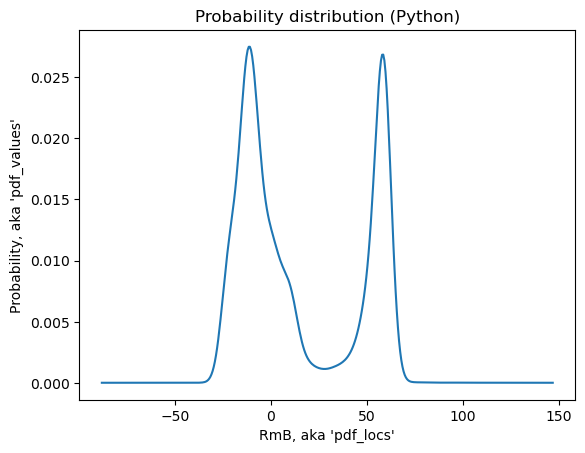

In [34]:
plt.plot(pdf_locs, pdf_values)
plt.xlabel("RmB, aka 'pdf_locs'")
plt.ylabel("Probability, aka 'pdf_values'")
plt.title("Probability distribution (Python)")

Encuentre las localizaciones de los picos de densidad (el pico negativo, J1, para los píxeles húmedos, el positivo, J2, para los secos

In [35]:
thresh_otsu = threshold_otsu(RmBsample)
thresh_weightings = [1/3, 2/3]
I1 = np.argwhere(pdf_locs < thresh_otsu)
J1 = np.argmax(pdf_values[I1])
I2 = np.argwhere(pdf_locs > thresh_otsu)
J2 = np.argmax(pdf_values[I2])

RmBwet = pdf_locs[I1[J1,0]]
RmBdry = pdf_locs[I2[J2,0]]

thresh = thresh_weightings[0]*RmBwet + thresh_weightings[1]*RmBdry

thresh

35.48788638262322

Representando todo hasta ahora en una sola parcela:

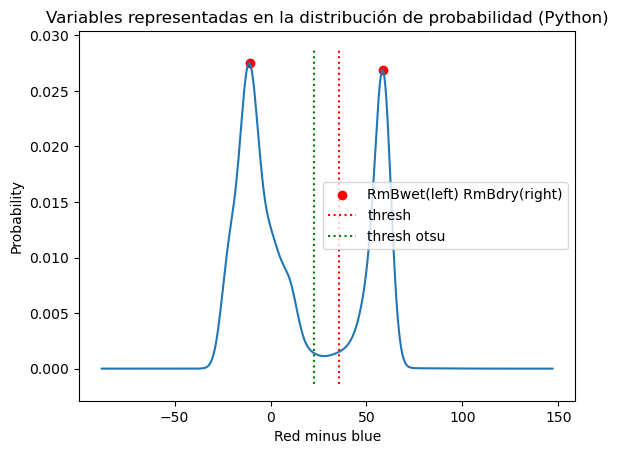

In [36]:
A = [pdf_locs[I1[J1,0]], pdf_locs[I2[J2,0]]]
B = [pdf_values[I1[J1,0]], pdf_values[I2[J2,0]]]

fig, axes = plt.subplots()
axes.plot(pdf_locs, pdf_values)
axes.scatter(A,B, color = 'r', marker = 'o',label='RmBwet(left) RmBdry(right)')
YL = axes.get_ylim()
axes.plot([thresh, thresh], YL, color = 'r', linestyle = ':',label='thresh')
axes.plot([thresh_otsu, thresh_otsu], YL, color = 'g', linestyle = ':', label='thresh otsu')
plt.xlabel("Red minus blue")
plt.ylabel("Probability")
plt.title("Variables representadas en la distribución de probabilidad (Python)")
axes.legend()

Recordatorio de la imagen del plan:

Text(0.5, 1.0, 'Plan Image (Python)')

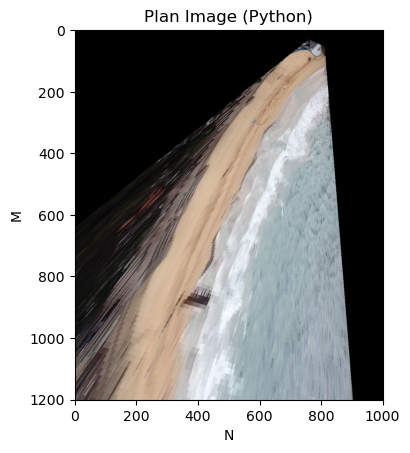

In [37]:
plt.imshow(Iplan.astype(int))
plt.xlabel("N")
plt.ylabel("M")
plt.title("Plan Image (Python)")

Iplan debe convertirse al formato float para que el cálculo de rojo menos azul funcione como se desea.
El formato float también es necesario para convertir un elemento del array a NaN (en la celda que utiliza np.nan más adelante).

In [38]:
Iplan = Iplan.astype("float")
RminusBdouble = Iplan[:,:,0] - Iplan[:,:,2]

Representación gráfica de los valores RmB en la imagen en planta:

Text(0.5, 1.0, 'Plan Red minus Blue Image (Python)')

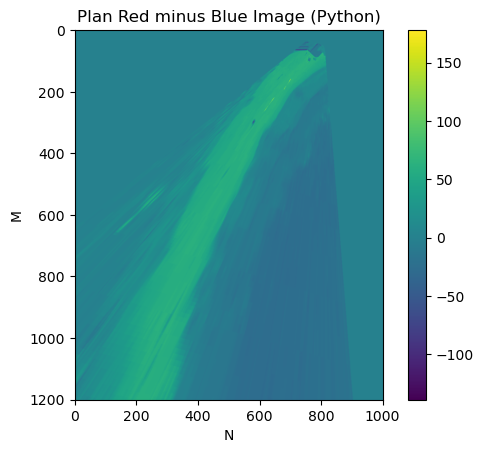

In [39]:
plt.imshow(RminusBdouble)
plt.colorbar()
plt.xlabel("N")
plt.ylabel("M")
plt.title("Plan Red minus Blue Image (Python)")

Generating the region of interest:

Text(0.5, 1.0, 'Region of interest (Python)')

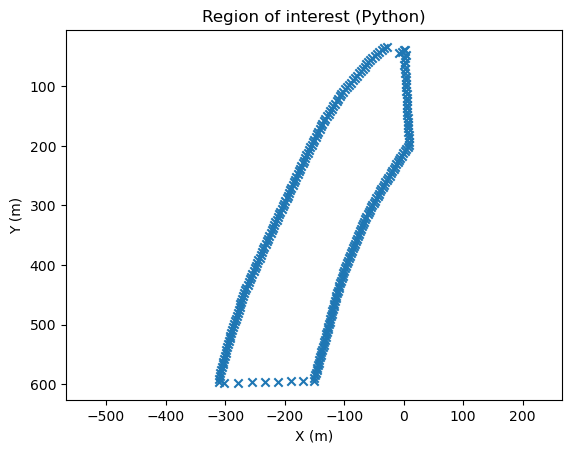

In [40]:
ROIx = np.concatenate((transectsX[0,:], np.flipud(transectsX[1,:])))
ROIy = np.concatenate((transectsY[0,:], np.flipud(transectsY[1,:])))
plt.scatter(ROIx,ROIy,marker='x')
plt.axis('equal')
plt.gca().invert_yaxis()
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.title("Region of interest (Python)")

Enmascarar la región fuera de la región de interés:

In [41]:
X = mat['X']
Y = mat['Y']
XFlat = X.flatten()
YFlat = Y.flatten()
points = np.column_stack((XFlat, YFlat))
verts = np.column_stack((ROIx, ROIy))
Imask = ~points_in_poly(points, verts)
Imask = np.reshape(Imask,[X.shape[0],X.shape[1]])
RminusBdouble[Imask] = np.nan

Trazado de la región aislada:

Text(0.5, 1.0, 'RminusBdouble in ROI (Python)')

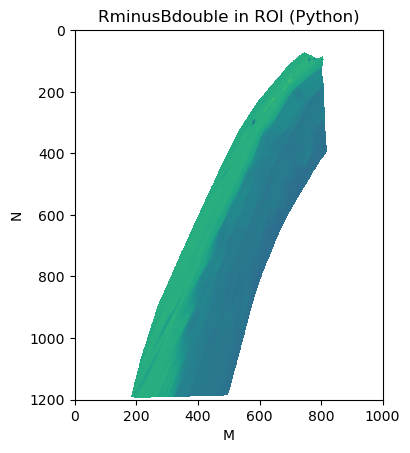

In [42]:
plt.imshow(RminusBdouble)
plt.xlabel("M")
plt.ylabel("N")
plt.title("RminusBdouble in ROI (Python)")

In [43]:
#defining thresh the same as that in MATLAB for testing
thresh = 34.36453958631399
c = find_contours(RminusBdouble,thresh)

Encuentra el número de vértices en cada uno de los contornos que representan el nivel umbral y añade esta información a la variable c_lengths.
A continuación, traza todos los contornos que representen el nivel umbral.

Text(0.5, 1.0, 'Contours on RminusBdouble (Python)')

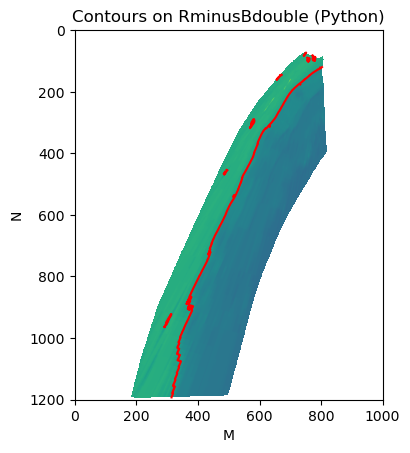

In [44]:
c_lengths = np.empty(0)
for i in range(len(c)):
    c_lengths = np.append(c_lengths, len(c[i]))

    plt.plot(c[i][:,1],c[i][:,0],'r-')

plt.imshow(RminusBdouble)
plt.xlabel("M")
plt.ylabel("N")
plt.title("Contours on RminusBdouble (Python)")

Identifique la ubicación del contorno más largo y, a continuación, trace su trazado.

In [45]:
longest_contour_loc = np.argmax(c_lengths)

Puntos de contorno de la línea de costa (nota: estas coordenadas no tienen el mismo formato que las de MATLAB):

Text(0.5, 1.0, 'Shoreline (Python)')

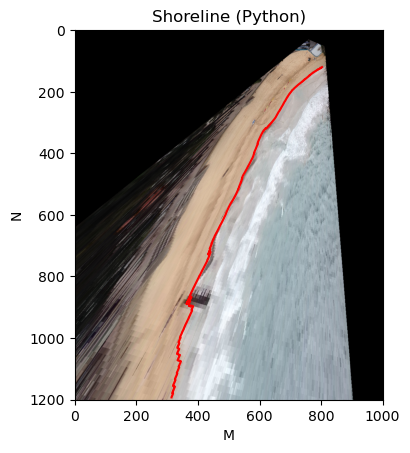

In [46]:
xyz_x = c[longest_contour_loc][:,1]
xyz_y = c[longest_contour_loc][:,0]
plt.plot(xyz_x,xyz_y, color = 'r')
plt.imshow(Iplan.astype("int"))
plt.xlabel("M")
plt.ylabel("N")
plt.title("Shoreline (Python)")

# Procesamiento de escenas almacenadas con ECFAS
Sólo procesa las escenas almacenadas en una carpeta de datos personalizada afinando los parámetros de índice de agua, severidad del enmascaramiento de nubes y filtrado por código de playa (extracción sólo en dos playas).
El número de productos a procesar se indica en el terminal de la ventana, respondiendo a la pregunta: Número de imágenes a reprocesar:)

In [47]:

%run py/saet_run.py --rm=op --wi=mndwi --cl=1 --of=data/NARRA --bc=1638,1759

2023-11-22 17:52:51,637 INFO Starting SAET algorithm...

2023-11-22 17:52:51,640 INFO Time passed: 0hour:0min:0sec

2023-11-22 17:52:51,640 INFO SAET algorithm have finished successfully.



<Figure size 640x480 with 0 Axes>

# Entrenar un nuevo clasificador para CoastSat

En este cuaderno el clasificador CoastSat se entrena utilizando imágenes de satélite de nuevos sitios. Esto puede mejorar la precisión de la detección de la línea de costa si los usuarios están experimentando problemas con el clasificador por defecto.
#### Configuración inicial

In [48]:
# coastsat modules
sys.path.insert(0, os.pardir)
# plotting params
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12
# filepaths 
filepath_images = os.path.join(os.getcwd(), 'data')
filepath_train = os.path.join(os.getcwd(), 'models')
filepath_models = os.path.join(os.getcwd(), 'models')
# settings
settings ={'filepath_train':filepath_train, # folder where the labelled images will be stored
           'cloud_thresh':0.9, # percentage of cloudy pixels accepted on the image
           'cloud_mask_issue':True, # set to True if problems with the default cloud mask 
           'pan_off': False, # set to True to disable pan-sharpening
           'inputs':{'filepath':filepath_images}, # folder where the images are stored
           'labels':{'sand':1,'white-water':2,'water':3,'other land features':4}, # labels for the classifier
           'colors':{'sand':[1, 0.65, 0],'white-water':[1,0,1],'water':[0.1,0.1,0.7],'other land features':[0.8,0.8,0.1]},
           'tolerance':0.01, # this is the pixel intensity tolerance, when using flood fill for sandy pixels
                             # set to 0 to select one pixel at a time
            }
        
# read kml files for the training sites
filepath_sites = os.path.join(os.getcwd(), 'kml')
train_sites = os.listdir(filepath_sites)
print('Sites for training:\n%s\n'%train_sites)

Sites for training:
['BYRON.kml', 'NEWCASTLE.kml', 'SAWTELL.kml']



### 1. Descargar imágenes

Para cada sitio en el que desee entrenar el clasificador, guarde un archivo .kml con la región de interés (5 vértices en el sentido de las agujas del reloj, el primer y el último punto son iguales, se puede crear a partir de Google myMaps) en la carpeta *\training_sites*.

Sólo necesitas unas pocas imágenes (~10) para entrenar el clasificador.

In [49]:
# download images at the sites
dates = ['2019-01-01', '2019-04-01']
sat_list = ['S2']
collection = 'C02'
sitename = 'NARRA'
for site in train_sites:
    polygon = SDS_tools.polygon_from_kml(os.path.join(filepath_sites,site))
    polygon = SDS_tools.smallest_rectangle(polygon)
    sitename = site[:site.find('.')]  
    inputs = {'polygon':polygon, 'dates':dates, 'sat_list':sat_list,
             'sitename':sitename, 'filepath':filepath_images,'landsat_collection': collection}
    print(sitename)
    metadata = SDS_download.retrieve_images(inputs)

BYRON
Number of images available between 2019-01-01 and 2019-04-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 17 images
  Total to download: 17 images

S2: 17 images
100%
Satellite images downloaded from GEE and save in /media/dacc/Elements/Códigos/Shore-Test/data/BYRON
NEWCASTLE
Number of images available between 2019-01-01 and 2019-04-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 32 images
  Total to download: 32 images

S2: 32 images
100%
Satellite images downloaded from GEE and save in /media/dacc/Elements/Códigos/Shore-Test/data/NEWCASTLE
SAWTELL


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

### 2. Etiquetar las imágenes

Etiqueta las imágenes en 4 clases: arena, aguas bravas, agua y otras características del terreno.

Las imágenes etiquetadas se guardan en *filepath_train* y pueden visualizarse posteriormente para el control de calidad. Si comete un error, no se preocupe, puede corregirlo más tarde borrando la imagen etiquetada.

In [ ]:
# label the images with an interactive annotator
#for site in train_sites:
#    settings['inputs']['sitename'] = site[:site.find('.')]
#    settings['inputs']['landsat_collection'] = collection
    # load metadata
#    metadata = SDS_download.get_metadata(settings['inputs'])
    # label images
#    SDS_classify.label_images(metadata,settings)


### 3. Entrenamiento del clasificador
Se entrena un Perceptrón Multicapa con *scikit-learn*. Para entrenar el clasificador, es necesario cargar los datos de entrenamiento.Puedes usar los datos que fueron etiquetados aquí y/o los datos de entrenamiento originales de CoastSat.

In [ ]:
# load labelled images
features = SDS_classify.load_labels(train_sites, settings)

# you can also load the original CoastSat training data (and optionally merge it with your labelled data)
with open(os.path.join(settings['filepath_train'], 'CoastSat_training_set_L8.pkl'), 'rb') as f:
    features_original = pickle.load(f)
for key in features_original.keys():
    print('%s : %d pixels'%(key,len(features_original[key])))
    

Ejecute esta sección para combinar los datos de entrenamiento originales con sus datos etiquetados:

In [ ]:
# add the white-water data from the original training data
features['white-water'] = np.append(features['white-water'], features_original['white-water'], axis=0)
# or merge all the classes
for key in features.keys():
    features[key] = np.append(features[key], features_original[key], axis=0)
features = features_original 
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

[OPCIONAL] Como las clases no tienen el mismo número de píxeles, es una buena práctica submuestrear las clases muy grandes (en este caso "agua" y "otras características del terreno"):

In [ ]:
# subsample randomly the land and water classes
# as the most important class is 'sand', the number of samples should be close to the number of sand pixels
#n_samples = 5000
#for key in ['water', 'other land features']:
#    features[key] =  features[key][np.random.choice(features[key].shape[0], n_samples, replace=False),:]
# print classes again
#for key in features.keys():
#    print('%s : %d pixels'%(key,len(features[key])))

Cuando los datos etiquetados estén listos, formatéalos en X, una matriz de características, e y, un vector de etiquetas:

In [ ]:
# format into X (features) and y (labels) 
classes = ['sand','white-water','water','other land features']
labels = [1,2,3,0]
X,y = SDS_classify.format_training_data(features, classes, labels)

Divida el conjunto de datos en entrenamiento y prueba: entrene el 70% de los datos y evalúe el 30% restante:

In [ ]:
# divide in train and test and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
classifier = MLPClassifier(hidden_layer_sizes=(100,50), solver='adam')
classifier.fit(X_train,y_train)
print('Accuracy: %0.4f' % classifier.score(X_test,y_test))

[OPCIONAL] Una evaluación más robusta es la validación cruzada de 10 veces (puede tardar unos minutos en ejecutarse):

In [ ]:
# cross-validation
#scores = cross_val_score(classifier, X, y, cv=10)
#print('Accuracy: %0.4f (+/- %0.4f)' % (scores.mean(), scores.std() * 2))

Trazar una matriz de confusión:

In [ ]:
# plot confusion matrix
%matplotlib inline
y_pred = classifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

Cuando esté satisfecho con la precisión y la matriz de confusión, entrene el modelo utilizando TODOS los datos de entrenamiento y guárdelo:

In [ ]:
# train with all the data and save the final classifier
classifier = MLPClassifier(hidden_layer_sizes=(100,50), solver='adam')
classifier.fit(X,y)
joblib.dump(classifier, os.path.join(filepath_models, 'NN_4classes_Landsat_test.pkl'))

### 4. Evaluar el clasificador

Cargue un clasificador que haya entrenado (especifique el nombre de archivo del clasificador) y evalúelo en las imágenes de satélite.

Esta sección guardará la salida de la clasificación para cada sitio en un directorio llamado \evaluation.

In [ ]:
# load and evaluate a classifier
#classifier = joblib.load(os.path.join(filepath_models, 'NN_4classes_Landsat_test.pkl'))
#settings['output_epsg'] = 3857
#settings['min_beach_area'] = 4500
#settings['buffer_size'] = 200
#settings['min_length_sl'] = 200
#settings['cloud_thresh'] = 0.5
#settings['dist_clouds'] = 100
#settings['inputs']['landsat_collection'] = 'C02'
## visualise the classified images
#for site in train_sites:
#    settings['inputs']['sitename'] = site[:site.find('.')]
#    # load metadata
#    metadata = SDS_download.get_metadata(settings['inputs'])
#   # plot the classified images
#    SDS_classify.evaluate_classifier(classifier,metadata,settings)